# Two-phase succinate flux landscape for yeast

This notebook compares **growth** and **stress** phases in _Saccharomyces cerevisiae_ using the yeast9 genome-scale metabolic model. We configure a rich YPD medium for the growth phase, switch to a water-only stress phase, and monitor succinate secretion together with pathway-specific flux groups (growth-associated reactions, oxidative/reductive TCA routes, and stress-protection reactions).

## 1. Prerequisites

* Create and activate a Python environment with COBRApy and plotting tools:

```bash
python -m venv .venv
source .venv/bin/activate
pip install cobra[glpk] pandas numpy matplotlib seaborn networkx
```

* Ensure this notebook runs from the repository root (`yeast-GEM`).

In [1]:
from pathlib import Path

# Ensure repository-specific helpers can locate configuration files
Path('.env').touch()
print('`.env` marker file present.')

`.env` marker file present.


In [2]:
import itertools
from typing import Dict, Iterable, List, Mapping, Optional
import warnings

import numpy as np
import pandas as pd
import cobra
from cobra import Model
from cobra.flux_analysis import pfba
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from code.io import read_yeast_model

sns.set_theme(style='whitegrid')
warnings.filterwarnings(
    'ignore',
    message="Solver status is 'infeasible'",
    category=UserWarning,
)

## 2. Load the yeast9 model

In [3]:
analysis_model: Model = read_yeast_model()

print(f'Reactions: {len(analysis_model.reactions)}')
print(f'Metabolites: {len(analysis_model.metabolites)}')
print(f'Genes: {len(analysis_model.genes)}')
print(f'Default objective: {analysis_model.objective.expression}')

Reactions: 4131
Metabolites: 2806
Genes: 1161
Default objective: 1.0*r_2111 - 1.0*r_2111_reverse_58b69


## 3. Media definitions and reaction groups

The helper sets below construct two media:

* **YPD growth**: glucose-rich medium with unlimited inorganic nutrients and modest amino acid uptake (approximate complex medium).
* **Water stress**: no exogenous carbon or nitrogen sources, with only water, protons, and oxygen available to simulate a distilled-water shock.

Flux groups highlight pathways of interest for succinate production analysis.

In [4]:

# Exchange reaction identifiers
GLUCOSE_EXCHANGE_ID = 'r_1714'
OXYGEN_EXCHANGE_ID = 'r_1992'
PROTON_EXCHANGE_ID = 'r_1832'
AMMONIUM_EXCHANGE_ID = 'r_1672'
PHOSPHATE_EXCHANGE_ID = 'r_2005'
SULFATE_EXCHANGE_ID = 'r_2060'
WATER_EXCHANGE_ID = 'r_2100'
SUCCINATE_EXCHANGE_ID = 'r_2056'
BIOMASS_REACTION_ID = 'r_2111'
MAINTENANCE_REACTION_ID = 'r_4046'
BIOMASS_ASSEMBLY_ID = 'r_4041'
GLYCEROL_EXCHANGE_ID = 'r_1808'
ETHANOL_EXCHANGE_ID = 'r_1761'

# Exchange reactions that receive constrained uptake in rich medium (representing amino acids and vitamins)
YPD_CONSTRAINED_UPTAKE: Iterable[str] = (
    'r_1604', 'r_1639', 'r_1873', 'r_1879', 'r_1880', 'r_1881', 'r_1671',
    'r_1883', 'r_1757', 'r_1891', 'r_1889', 'r_1810', 'r_1993', 'r_1893',
    'r_1897', 'r_1947', 'r_1899', 'r_1900', 'r_1902', 'r_1967', 'r_1903',
    'r_1548', 'r_1904', 'r_2028', 'r_2038', 'r_1906', 'r_2067', 'r_1911',
    'r_1912', 'r_1913', 'r_2090', 'r_1914', 'r_2106',
)

# Exchange reactions that remain unconstrained for uptake (-1000 lower bound)
ESSENTIAL_INORGANICS: Iterable[str] = (
    AMMONIUM_EXCHANGE_ID,  # ammonium
    'r_1654',               # potassium
    OXYGEN_EXCHANGE_ID,
    PHOSPHATE_EXCHANGE_ID,
    SULFATE_EXCHANGE_ID,
    'r_1861',               # iron
    PROTON_EXCHANGE_ID,
    WATER_EXCHANGE_ID,
    'r_4593',               # chloride
    'r_4595',               # manganese
    'r_4596',               # zinc
    'r_4597',               # magnesium
    'r_2049',               # sodium
    'r_4594',               # copper
    'r_4600',               # calcium
    'r_2020',               # sulfate/glutathione coupled import
)

# Baseline media for each phase
YPD_MEDIUM_BOUNDS: Dict[str, float] = {
    GLUCOSE_EXCHANGE_ID: -20.0,
    OXYGEN_EXCHANGE_ID: -20.0,
    AMMONIUM_EXCHANGE_ID: -15.0,
    PHOSPHATE_EXCHANGE_ID: -10.0,
    SULFATE_EXCHANGE_ID: -10.0,
    PROTON_EXCHANGE_ID: -100.0,
    WATER_EXCHANGE_ID: -1000.0,
}

# Apply modest uptake for amino acids and vitamins to mimic complex medium components
for rxn_id in YPD_CONSTRAINED_UPTAKE:
    YPD_MEDIUM_BOUNDS.setdefault(rxn_id, -2.0)

for rxn_id in ESSENTIAL_INORGANICS:
    YPD_MEDIUM_BOUNDS.setdefault(rxn_id, -1000.0)

# Distilled-water shock medium with no carbon or nitrogen sources
WATER_STRESS_BOUNDS: Dict[str, float] = {
    WATER_EXCHANGE_ID: -1000.0,
    PROTON_EXCHANGE_ID: -20.0,
    OXYGEN_EXCHANGE_ID: -10.0,
}

# Flux groups for reporting (net and absolute flux will be summarised per group)
FLUX_GROUPS: Dict[str, List[str]] = {
    'growth_programme': [BIOMASS_REACTION_ID, BIOMASS_ASSEMBLY_ID, MAINTENANCE_REACTION_ID],
    'oxidative_tca_cycle': ['r_0432', 'r_0108', 'r_0884', 'r_0885', 'r_0118', 'r_1212', 'r_1216', 'r_0765', 'r_0952'],
    'reductive_tca_glyoxylate': ['r_0662', 'r_0716', 'r_0156', 'r_0717', 'r_1051', 'r_0194'],
    'stress_adaptation': ['r_0463', 'r_0511', 'r_1051', 'r_1808', 'r_1761', 'r_4048'],
}

# Metabolite IDs useful for reserve drain reactions (optional)
RESERVE_METABOLITES: Dict[str, str] = {
    'glycogen_c': 's_0773',
    'trehalose_c': 's_1520',
}


## 4. Helper functions

Utility functions configure media, apply user overrides, evaluate each phase, and assemble comparison tables.

In [5]:

def reset_exchange_bounds(model: Model) -> None:
    for rxn in model.exchanges:
        rxn.lower_bound = 0.0
        rxn.upper_bound = 1000.0


def apply_medium(model: Model, bounds: Mapping[str, float]) -> None:
    for rxn_id, lower_bound in bounds.items():
        if rxn_id in model.reactions:
            model.reactions.get_by_id(rxn_id).lower_bound = float(lower_bound)


def apply_condition_overrides(model: Model, overrides: Optional[Mapping[str, float]] = None) -> None:
    if not overrides:
        return
    reaction_map = {
        'glucose_limit': GLUCOSE_EXCHANGE_ID,
        'oxygen_limit': OXYGEN_EXCHANGE_ID,
        'proton_limit': PROTON_EXCHANGE_ID,
        'ammonium_limit': AMMONIUM_EXCHANGE_ID,
        'succinate_minimum': SUCCINATE_EXCHANGE_ID,
    }
    for key, value in overrides.items():
        rxn_id = reaction_map.get(key)
        if rxn_id and rxn_id in model.reactions:
            model.reactions.get_by_id(rxn_id).lower_bound = float(value)


def enable_reserve_release(model: Model, reserves: Optional[Mapping[str, float]] = None) -> None:
    """Configure reversible reserve-release sinks for the provided metabolites.

    Each reserve entry specifies the maximum uptake (release into the cytosol) in
    mmol gDW^-1 h^-1 allowed during the stress phase. The reaction lower bound is
    set to the negative of this limit so that the solver can import the reserve
    metabolite up to the configured rate.
    """
    if not reserves:
        return
    for label, limit in reserves.items():
        if limit is None or float(limit) <= 0:
            continue
        met_id = RESERVE_METABOLITES.get(label)
        if not met_id or met_id not in model.metabolites:
            continue
        met = model.metabolites.get_by_id(met_id)
        reaction_id = f"reserve_release_{met.id}"
        if reaction_id in model.reactions:
            boundary_rxn = model.reactions.get_by_id(reaction_id)
        else:
            boundary_rxn = model.add_boundary(met, type='sink', reaction_id=reaction_id)
        boundary_rxn.lower_bound = -float(limit)
        boundary_rxn.upper_bound = 1000.0


def summarise_flux_groups(model: Model, fluxes: pd.Series, phase: str) -> pd.DataFrame:
    rows = []
    for group, rxn_ids in FLUX_GROUPS.items():
        present = [rxn_id for rxn_id in rxn_ids if rxn_id in fluxes.index]
        if not present:
            continue
        values = fluxes.loc[present]
        rows.append({
            'phase': phase,
            'group': group,
            'net_flux': float(values.sum()),
            'total_abs_flux': float(np.abs(values).sum()),
        })
    return pd.DataFrame(rows)


def collect_group_reaction_fluxes(model: Model, fluxes: pd.Series, phase: str) -> pd.DataFrame:
    rows = []
    for group, rxn_ids in FLUX_GROUPS.items():
        for rxn_id in rxn_ids:
            if rxn_id not in model.reactions or rxn_id not in fluxes.index:
                continue
            rxn = model.reactions.get_by_id(rxn_id)
            value = float(fluxes[rxn_id])
            rows.append({
                'phase': phase,
                'group': group,
                'reaction_id': rxn_id,
                'name': rxn.name,
                'flux': value,
                'abs_flux': abs(value),
                'subsystem': rxn.subsystem,
            })
    return pd.DataFrame(rows)


def evaluate_phase(
    base_model: Model,
    phase_name: str,
    medium_bounds: Mapping[str, float],
    overrides: Optional[Mapping[str, float]] = None,
    reserve_release: Optional[Mapping[str, float]] = None,
    objective_rxn_id: str = SUCCINATE_EXCHANGE_ID,
) -> Dict[str, object]:
    model = base_model.copy()
    reset_exchange_bounds(model)
    apply_medium(model, medium_bounds)
    apply_condition_overrides(model, overrides)
    enable_reserve_release(model, reserve_release)

    if objective_rxn_id in model.reactions:
        model.objective = model.reactions.get_by_id(objective_rxn_id)

    solution = pfba(model)
    result = {
        'phase': phase_name,
        'status': solution.status,
        'succinate_flux': np.nan,
        'biomass_flux': np.nan,
        'group_summary': pd.DataFrame(),
        'reaction_fluxes': pd.DataFrame(),
        'solution': solution,
    }

    if solution.status != 'optimal':
        return result

    fluxes = solution.fluxes
    result['succinate_flux'] = float(fluxes.get(SUCCINATE_EXCHANGE_ID, np.nan))
    result['biomass_flux'] = float(fluxes.get(BIOMASS_REACTION_ID, np.nan))
    result['group_summary'] = summarise_flux_groups(model, fluxes, phase_name)
    result['reaction_fluxes'] = collect_group_reaction_fluxes(model, fluxes, phase_name)
    return result


def evaluate_two_phase_scenario(
    base_model: Model,
    growth_overrides: Optional[Mapping[str, float]] = None,
    stress_overrides: Optional[Mapping[str, float]] = None,
    stress_reserve_release: Optional[Mapping[str, float]] = None,
) -> Dict[str, object]:
    growth_result = evaluate_phase(
        base_model,
        phase_name='growth',
        medium_bounds=YPD_MEDIUM_BOUNDS,
        overrides=growth_overrides,
    )
    stress_result = evaluate_phase(
        base_model,
        phase_name='stress',
        medium_bounds=WATER_STRESS_BOUNDS,
        overrides=stress_overrides,
        reserve_release=stress_reserve_release,
    )

    phase_summary = pd.DataFrame([
        {k: v for k, v in res.items() if k in {'phase', 'status', 'succinate_flux', 'biomass_flux'}}
        for res in (growth_result, stress_result)
    ])

    group_summary = pd.concat(
        [res['group_summary'] for res in (growth_result, stress_result) if not res['group_summary'].empty],
        ignore_index=True,
    ) if any(not res['group_summary'].empty for res in (growth_result, stress_result)) else pd.DataFrame()

    reaction_fluxes = pd.concat(
        [res['reaction_fluxes'] for res in (growth_result, stress_result) if not res['reaction_fluxes'].empty],
        ignore_index=True,
    ) if any(not res['reaction_fluxes'].empty for res in (growth_result, stress_result)) else pd.DataFrame()

    return {
        'phase_summary': phase_summary,
        'group_summary': group_summary,
        'reaction_fluxes': reaction_fluxes,
        'raw': {'growth': growth_result, 'stress': stress_result},
    }


def plot_phase_summary(phase_summary: pd.DataFrame) -> None:
    if phase_summary.empty:
        print('No phase summary available to plot.')
        return
    melted = phase_summary.melt(id_vars=['phase', 'status'], value_vars=['succinate_flux', 'biomass_flux'])
    plt.figure(figsize=(8, 4))
    ax = sns.barplot(data=melted, x='phase', y='value', hue='variable')
    ax.set_ylabel('Flux (mmol gDW$^{-1}$ h$^{-1}$)')
    ax.set_xlabel('Phase')
    ax.set_title('Succinate secretion and biomass flux per phase')
    plt.legend(title='Metric')
    plt.tight_layout()
    plt.show()


def plot_group_heatmap(group_summary: pd.DataFrame, value_column: str = 'total_abs_flux') -> None:
    if group_summary.empty:
        print('No group flux summary available to plot.')
        return
    pivot = group_summary.pivot(index='group', columns='phase', values=value_column).fillna(0.0)
    plt.figure(figsize=(6, 4))
    sns.heatmap(pivot, annot=True, fmt='.2f', cmap='mako_r')
    plt.title(f'Flux distribution across phases ({value_column})')
    plt.ylabel('Flux group')
    plt.xlabel('Phase')
    plt.tight_layout()
    plt.show()


## 5. Configure baseline conditions

Adjust the dictionaries below to explore alternative uptake limits. Bounds use the COBRA convention (negative values indicate uptake).

In [6]:

# Growth phase overrides (applied on top of the default YPD medium)
growth_conditions = {
    'glucose_limit': -20.0,
    'oxygen_limit': -20.0,
    'proton_limit': -100.0,
    'ammonium_limit': -15.0,
}

# Stress phase overrides (water shock). Keep oxygen available but remove external carbon.
stress_conditions = {
    'oxygen_limit': -10.0,
    'proton_limit': -20.0,
}

# Optional reserve release (mmol gDW^-1 h^-1) to mimic mobilisation of stored carbohydrates/lipids during stress.
# Set values to zero or remove entries if you prefer a strict no-reserve scenario.
stress_reserve_release = {
    'glycogen_c': 2.0,
    'trehalose_c': 1.0,
}


## 6. Evaluate the two-phase scenario

In [7]:
results = evaluate_two_phase_scenario(
    analysis_model,
    growth_overrides=growth_conditions,
    stress_overrides=stress_conditions,
    stress_reserve_release=stress_reserve_release,
)

phase_summary = results['phase_summary']
group_summary = results['group_summary']
reaction_fluxes = results['reaction_fluxes']

print('Phase summary:')
display(phase_summary)

print('Flux group summary:')
if group_summary.empty:
    print('No flux groups reported (check solver status).')
else:
    display(group_summary)

print('Reaction-level fluxes:')
if reaction_fluxes.empty:
    print('No reaction fluxes recorded (check solver status).')
else:
    display(reaction_fluxes.sort_values(['phase', 'group', 'abs_flux'], ascending=[True, True, False]))


Phase summary:


,phase,status,succinate_flux,biomass_flux
0,growth,optimal,45.625882,0.0
1,stress,optimal,6.000000,0.0


Flux group summary:


,phase,group,net_flux,total_abs_flux
0,growth,growth_programme,7.000000e-01,7.000000e-01
1,growth,oxidative_tca_cycle,2.000000e+00,2.000000e+00
2,growth,reductive_tca_glyoxylate,0.000000e+00,0.000000e+00
3,growth,stress_adaptation,-2.072171e-14,2.072171e-14
4,stress,growth_programme,7.000000e-01,7.000000e-01
5,stress,oxidative_tca_cycle,0.000000e+00,0.000000e+00
6,stress,reductive_tca_glyoxylate,1.000000e+00,1.000000e+00
7,stress,stress_adaptation,2.000000e+00,2.000000e+00


Reaction-level fluxes:


,phase,group,reaction_id,name,flux,abs_flux,subsystem
2,growth,growth_programme,r_4046,non-growth associated maintenance reaction,7.000000e-01,7.000000e-01,Growth
0,growth,growth_programme,r_2111,growth,0.000000e+00,0.000000e+00,Exchange reaction
1,growth,growth_programme,r_4041,biomass pseudoreaction,0.000000e+00,0.000000e+00,Growth
8,growth,oxidative_tca_cycle,r_1216,L-proline transport,2.000000e+00,2.000000e+00,"Transport [c, e]"
3,growth,oxidative_tca_cycle,r_0108,acetyl-Coa carboxylase,0.000000e+00,0.000000e+00,Fatty acid biosynthesis
4,growth,oxidative_tca_cycle,r_0884,phosphoenolpyruvate carboxykinase,0.000000e+00,0.000000e+00,Glycolysis / gluconeogenesis
5,growth,oxidative_tca_cycle,r_0885,phosphoethanolamine cytidyltransferase,0.000000e+00,0.000000e+00,Glycerophospholipid metabolism
6,growth,oxidative_tca_cycle,r_0118,acteylornithine transaminase,0.000000e+00,0.000000e+00,Arginine biosynthesis
7,growth,oxidative_tca_cycle,r_1212,L-lysine transport,0.000000e+00,0.000000e+00,"Transport [c, v]"
9,growth,oxidative_tca_cycle,r_0765,NAD kinase,0.000000e+00,0.000000e+00,Nicotinate and nicotinamide metabolism


## 7. Visualise phase contrasts

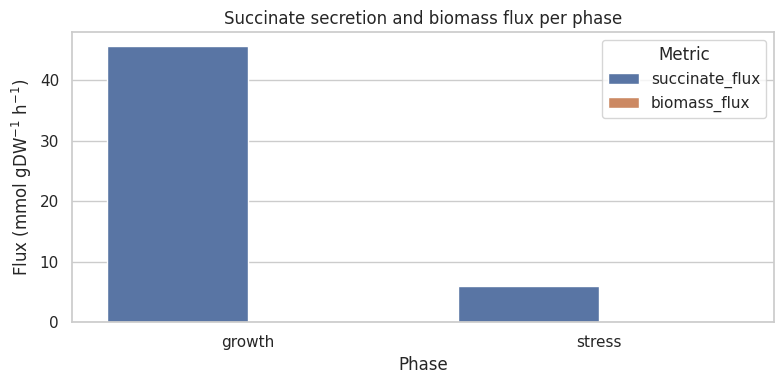

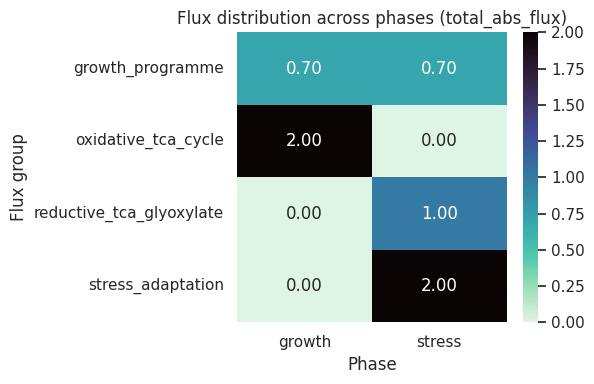

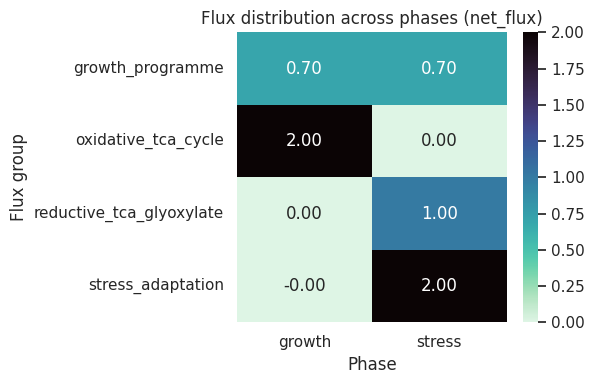

In [8]:

plot_phase_summary(phase_summary)
plot_group_heatmap(group_summary, value_column='total_abs_flux')
plot_group_heatmap(group_summary, value_column='net_flux')


## 8. Inspect key reactions per phase

The tables below highlight the largest-magnitude reactions in each group so you can identify which enzymes dominate during growth vs. stress.

In [9]:

if reaction_fluxes.empty:
    print('No reaction fluxes available for inspection.')
else:
    top_reactions = (
        reaction_fluxes
        .sort_values('abs_flux', ascending=False)
        .groupby(['phase', 'group'])
        .head(5)
        .reset_index(drop=True)
    )
    display(top_reactions)


,phase,group,reaction_id,name,flux,abs_flux,subsystem
0,growth,oxidative_tca_cycle,r_1216,L-proline transport,2.000000e+00,2.000000e+00,"Transport [c, e]"
1,stress,stress_adaptation,r_0511,glycogen phosphorylase,2.000000e+00,2.000000e+00,Starch and sucrose metabolism
2,stress,reductive_tca_glyoxylate,r_0194,"alpha,alpha-trehalase",1.000000e+00,1.000000e+00,Starch and sucrose metabolism
3,growth,growth_programme,r_4046,non-growth associated maintenance reaction,7.000000e-01,7.000000e-01,Growth
4,stress,growth_programme,r_4046,non-growth associated maintenance reaction,7.000000e-01,7.000000e-01,Growth
5,growth,stress_adaptation,r_0511,glycogen phosphorylase,-2.072171e-14,2.072171e-14,Starch and sucrose metabolism
6,stress,reductive_tca_glyoxylate,r_0716,malate synthase,-7.386974e-17,7.386974e-17,Pyruvate metabolism
7,stress,reductive_tca_glyoxylate,r_0662,isocitrate lyase,-3.693487e-17,3.693487e-17,Glyoxylate and dicarboxylate metabolism
8,stress,reductive_tca_glyoxylate,r_0717,malate synthase,3.693487e-17,3.693487e-17,Pyruvate metabolism
9,growth,oxidative_tca_cycle,r_0108,acetyl-Coa carboxylase,0.000000e+00,0.000000e+00,Fatty acid biosynthesis


## 9. Notes on stress modelling

* Reserve-release settings now create reversible sink reactions with a negative lower bound equal to the requested release rate. Increase the magnitude to let the stress model import more of the stored metabolite, or set the value to zero to disable that reserve.
* If the stress phase becomes infeasible (no feasible steady-state), relax proton or oxygen limits, or allow minimal amino acid uptake to sustain maintenance energy.
* You can change the optimisation objective by passing a different `objective_rxn_id` to `evaluate_phase` if you want to compare biomass-maximising vs. succinate-maximising behaviour.